# Imports & basic configuration

In [1]:
import os
import sys
# install the package if not yet installed
try:
    from branch.branch import Net
except:
    !python -m pip install git+https://github.com/nguwijy/deep_branching_with_domain.git
    from branch.branch import Net
import math
from scipy import special
import numpy as np
import torch
import matplotlib.pyplot as plt
import time
import logging
from pynverse import inversefunc
from branch.galerkin import DGMNet
from branch.bsde import BSDENet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# perfect reproducibility is not guaranteed with different version of torch
#
print(f"torch version: {torch.__version__}")

torch version: 1.13.1+cu117


In [3]:
print("Information of the allocated GPU.")
!nvidia-smi

Information of the allocated GPU.
Sun Apr 23 15:21:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A4000    On   | 00000000:21:00.0  On |                  Off |
| 41%   39C    P8    20W / 140W |   2777MiB / 16376MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                      

In [4]:
# performance evaluation for PDE
def compare_performance(
    grid_1d,
    grid_nd,
    grid_with_t,
    t_lo,
    true,
    terminal,
    fname=None,
    debug_mode=False,
    disable_galerkin=False,
    disable_bsde=False,
    disable_branch=False,
    seeds=list(range(10)),
    disable_relative=False,
    **kwargs,
):
    if not os.path.isdir('logs/deep_branching/data/'):
        os.makedirs('logs/deep_branching/data/')
    if not os.path.isdir('logs/deep_branching/plot/'):
        os.makedirs('logs/deep_branching/plot/')
    x_lo, x_hi = grid_nd.min(), grid_nd.max()
    grid_nd = grid_nd.astype(np.float32)
    grid_with_t = grid_with_t.astype(np.float32)
    
    problem_name = fname
    fname = f"{fname}_dim_{grid_nd.shape[0]}" if fname is not None else None
    counter = 1

    branch_runtime, branch_l1_error, branch_l2_error, branch_rel_error, branch = (
        [],
        [],
        [],
        [],
        0,
    )
    branch_fdb_runtime, branch_total_runtime = [], []
    dgm_runtime, dgm_l1_error, dgm_l2_error, dgm_rel_error, dgm = [], [], [], [], 0
    bsde_runtime, bsde_l1_error, bsde_l2_error, bsde_rel_error, bsde = [], [], [], [], 0
    for seed in seeds:
        ######### Deep branching method
        if not disable_branch:
            torch.manual_seed(seed)
            print(
                f"#### Starting deep branching method with seed {seed} - {counter} out of {len(seeds)} times"
            )
            start = time.time()
            model = Net(t_lo=t_lo, t_hi=t_lo, x_lo=x_lo, x_hi=x_hi, problem_name=problem_name, **kwargs)
            model.train_and_eval(debug_mode)
            branch_total_runtime.append(time.time() - start)
            branch_fdb_runtime.append(model.fdb_runtime)
            branch_runtime.append(branch_total_runtime[-1] - branch_fdb_runtime[-1])
            # note that branch output batch_size x 1 instead of batch_size like other algo
            tmp = (
                model(torch.tensor(grid_with_t.T, device=device), patch=model.patches - 1)[:, 0].detach().cpu().numpy()
            )
            branch += tmp
            branch_l1_error.append((np.abs(tmp - true)).mean())
            branch_l2_error.append(((tmp - true) ** 2).mean())
            if not disable_relative:
                branch_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
            else:
                branch_rel_error.append(0)
            print(
                f"Time taken: {branch_runtime[-1]:.0f} seconds; L1 error: {branch_l1_error[-1]:.2E}; L2 error: {branch_l2_error[-1]:.2E}; rel error: {branch_rel_error[-1]:.2E}."
            )
            print(
                f"fdb runtime: {branch_fdb_runtime[-1]:.0f} seconds; total runtime: {branch_total_runtime[-1]:.0f} seconds."
            )

        ######### Deep galerkin method
        if not disable_galerkin:
            torch.manual_seed(seed)
            print(
                f"#### Starting deep galerkin method with seed {seed} - {counter} out of {len(seeds)} times"
            )
            start = time.time()
            model = DGMNet(t_lo=t_lo, t_hi=kwargs["T"], x_lo=x_lo, x_hi=x_hi, **kwargs)
            model.train_and_eval(debug_mode)
            dgm_runtime.append(time.time() - start)
            tmp = (
                model(torch.tensor(grid_with_t.T, device=device)).detach().cpu().numpy()
            )
            dgm += tmp
            dgm_l1_error.append((np.abs(tmp - true)).mean())
            dgm_l2_error.append(((tmp - true) ** 2).mean())
            if not disable_relative:
                dgm_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
            else:
                dgm_rel_error.append(0)
            print(
                f"Time taken: {dgm_runtime[-1]:.0f} seconds; L1 error: {dgm_l1_error[-1]:.2E}; L2 error: {dgm_l2_error[-1]:.2E}; rel error: {dgm_rel_error[-1]:.2E}."
            )

        ######### Deep BSDE method
        if not disable_bsde:
            torch.manual_seed(seed)
            print(
                f"#### Starting deep BSDE method with seed {seed} - {counter} out of {len(seeds)} times"
            )
            start = time.time()
            model = BSDENet(t_lo=t_lo, t_hi=kwargs["T"], x_lo=x_lo, x_hi=x_hi, **kwargs)
            model.train_and_eval(debug_mode)
            bsde_runtime.append(time.time() - start)
            tmp = (
                model(torch.tensor(grid_nd.T, device=device))
                .squeeze(-1)
                .detach()
                .cpu()
                .numpy()
            )
            bsde += tmp
            bsde_l1_error.append((np.abs(tmp - true)).mean())
            bsde_l2_error.append(((tmp - true) ** 2).mean())
            if not disable_relative:
                bsde_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
            else:
                bsde_rel_error.append(0)
            print(
                f"Time taken: {bsde_runtime[-1]:.0f} seconds; L1 error: {bsde_l1_error[-1]:.2E}; L2 error: {bsde_l2_error[-1]:.2E}; rel error: {bsde_rel_error[-1]:.2E}."
            )

        print("\n")
        counter += 1

    # Plot
    f = plt.figure()
    plt.plot(grid_1d, true, label="True solution")
    plt.plot(grid_1d, terminal, label="Terminal condition")
    # save into csv
    if fname is not None:
        plt_data = np.stack((grid_1d, true, terminal), axis=-1)
        plt_header = "x, true, terminal"

    if not disable_branch:
        branch /= len(seeds)
        branch_runtime, branch_l1_error, branch_l2_error, branch_rel_error = (
            np.array(branch_runtime),
            np.array(branch_l1_error),
            np.array(branch_l2_error),
            np.array(branch_rel_error),
        )
        branch_fdb_runtime, branch_total_runtime = np.array(
            branch_fdb_runtime
        ), np.array(branch_total_runtime)
        print("\n")
        print("######## Summary for deep branching method")
        print(f"runtime:        {branch_runtime.mean():.0f}")
        print(f"fdb runtime:    {branch_fdb_runtime.mean():.0f}")
        print(f"total runtime:  {branch_total_runtime.mean():.0f}")
        print(f"mean L1 error:  {branch_l1_error.mean():.2E}")
        print(f"std L1 error:   {branch_l1_error.std():.2E}")
        print(f"mean L2 error:  {branch_l2_error.mean():.2E}")
        print(f"std L2 error:   {branch_l2_error.std():.2E}")
        print(f"mean rel error: {branch_rel_error.mean():.2E}")
        print(f"std rel error:  {branch_rel_error.std():.2E}")
        # Plot
        plt.plot(grid_1d, branch, label="Deep branching")
        # save into csv
        if fname is not None:
            plt_data = np.concatenate(
                (plt_data, np.expand_dims(branch, axis=-1)), axis=-1
            )
            plt_header += ", branch"
            data = np.stack(
                (branch_runtime, branch_l1_error, branch_l2_error, branch_rel_error),
                axis=-1,
            )
            np.savetxt(
                "logs/deep_branching/data/branch_" + fname + ".csv",
                data,
                delimiter=",",
                header="runtime,l1_error,l2_error,rel_error",
                comments="",
            )

    if not disable_galerkin:
        dgm /= len(seeds)
        dgm_runtime, dgm_l1_error, dgm_l2_error, dgm_rel_error = (
            np.array(dgm_runtime),
            np.array(dgm_l1_error),
            np.array(dgm_l2_error),
            np.array(dgm_rel_error),
        )
        print("\n")
        print("######## Summary for deep galerkin method")
        print(f"runtime:        {dgm_runtime.mean():.0f}")
        print(f"mean L1 error:  {dgm_l1_error.mean():.2E}")
        print(f"std L1 error:   {dgm_l1_error.std():.2E}")
        print(f"mean L2 error:  {dgm_l2_error.mean():.2E}")
        print(f"std L2 error:   {dgm_l2_error.std():.2E}")
        print(f"mean rel error: {dgm_rel_error.mean():.2E}")
        print(f"std rel error:  {dgm_rel_error.std():.2E}")
        # Plot
        plt.plot(grid_1d, dgm, label="Deep Galerkin")
        # save into csv
        if fname is not None:
            plt_data = np.concatenate((plt_data, np.expand_dims(dgm, axis=-1)), axis=-1)
            plt_header += ", dgm"
            data = np.stack(
                (dgm_runtime, dgm_l1_error, dgm_l2_error, dgm_rel_error), axis=-1
            )
            np.savetxt(
                "logs/deep_branching/data/dgm_" + fname + ".csv",
                data,
                delimiter=",",
                header="runtime,l1_error,l2_error,rel_error",
                comments="",
            )

    ######### Deep BSDE method
    if not disable_bsde:
        bsde /= len(seeds)
        bsde_runtime, bsde_l1_error, bsde_l2_error, bsde_rel_error = (
            np.array(bsde_runtime),
            np.array(bsde_l1_error),
            np.array(bsde_l2_error),
            np.array(bsde_rel_error),
        )
        print("\n")
        print("######## Summary for deep BSDE method")
        print(f"runtime:        {bsde_runtime.mean():.0f}")
        print(f"mean L1 error:  {bsde_l1_error.mean():.2E}")
        print(f"std L1 error:   {bsde_l1_error.std():.2E}")
        print(f"mean L2 error:  {bsde_l2_error.mean():.2E}")
        print(f"std L2 error:   {bsde_l2_error.std():.2E}")
        print(f"mean rel error: {bsde_rel_error.mean():.2E}")
        print(f"std rel error:  {bsde_rel_error.std():.2E}")
        # Plot
        plt.plot(grid_1d, bsde, label="Deep BSDE")
        # save into csv
        if fname is not None:
            plt_data = np.concatenate(
                (plt_data, np.expand_dims(bsde, axis=-1)), axis=-1
            )
            plt_header += ", bsde"
            data = np.stack(
                (bsde_runtime, bsde_l1_error, bsde_l2_error, bsde_rel_error), axis=-1
            )
            np.savetxt(
                "logs/deep_branching/data/bsde_" + fname + ".csv",
                data,
                delimiter=",",
                header="runtime,l1_error,l2_error,rel_error",
                comments="",
            )

    plt.legend()
    plt.show()
    f.savefig(f"logs/deep_branching/plot/{'comparison' if fname is None else fname}.pdf")
    if fname is not None:
        np.savetxt(
            "logs/deep_branching/data/plt_" + fname + ".csv", plt_data, delimiter=",", header=plt_header, comments=""
        )

In [5]:
def f_example(y, coordinate=0):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> second deriv
    """
    return ( y[0] - (2 + dim ) / 2 / dim ) * dim * y[1:(dim+1)].sum(dim=0) 
    
def dgm_f_example(y, coordinate=0):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> second deriv
    """
    return (( y[0] - (2 + dim ) / 2 / dim ) * dim * y[1:(dim+1)].sum(dim=0) + dim * dim * y[(dim+1):(2*dim+1)].sum(dim=0) / 2 )

def phi_example(x, coordinate=0):
    return torch.exp( T + x.sum(axis=0) / dim ) / (1 + torch.exp( T + x.sum(axis=0) / dim ) )
        
def exact_example(t, x, T):
    xi = t + x.sum(axis=0) / dim 
    return 1 / (1 + np.exp( - xi ) )

t_lo, x_lo, x_hi = 0., -5., 5.
    
x_mid = (x_lo + x_hi) / 2
grid = np.linspace(x_lo, x_hi, 100)

#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 65 seconds; L1 error: 6.57E-04; L2 error: 6.14E-07; rel error: 8.83E-03.
fdb runtime: 0 seconds; total runtime: 65 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 79 seconds; L1 error: 4.68E-04; L2 error: 2.86E-07; rel error: 9.84E-03.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 136 seconds; L1 error: 3.50E-03; L2 error: 1.73E-05; rel error: 2.03E-02.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 61 seconds; L1 error: 4.65E-04; L2 error: 3.01E-07; rel error: 9.30E-03.
fdb runtime: 0 seconds; total runtime: 61 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 86 seconds; L1 error: 4.12E-04; L2 error: 2.39E-07; rel error: 1.23E-02.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 144 seconds; L1 error: 3.97E-03; L2 error: 2.83E-05; rel error: 2.18E-02.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 65 seconds; L1 error: 7.46E-04; L2 error: 9.37E-07; rel error: 1.25E-02.
fdb runtime: 0 seconds; total runtime: 65 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 85 seconds; L1 error: 5.17E-04; L2 error: 4.07E-07; rel error: 8.16E-03.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 145 seconds; L1 error: 2.82E-03; L2 error: 9.54E-06; rel error: 3.96E-02.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 64 seconds; L1 error: 4.44E-04; L2 error: 2.59E-07; rel error: 7.31E-03.
fdb runtime: 0 seconds; total runtime: 64 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 78 seconds; L1 error: 7.11E-04; L2 error: 6.36E-07; rel error: 1.02E-02.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 139 seconds; L1 error: 1.63E-03; L2 error: 3.55E-06; rel error: 4.05E-02.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 61 seconds; L1 error: 4.95E-04; L2 error: 3.46E-07; rel error: 7.53E-03.
fdb runtime: 0 seconds; total runtime: 61 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 79 seconds; L1 error: 4.66E-04; L2 error: 2.81E-07; rel error: 4.95E-03.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 141 seconds; L1 error: 5.38E-03; L2 error: 3.30E-05; rel error: 5.76E-02.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 61 seconds; L1 error: 3.56E-04; L2 error: 1.68E-07; rel error: 3.97E-03.
fdb runtime: 0 seconds; total runtime: 61 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 84 seconds; L1 error: 5.12E-04; L2 error: 3.62E-07; rel error: 5.00E-03.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 145 seconds; L1 error: 1.21E-03; L2 error: 2.21E-06; rel error: 1.03E-02.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 62 seconds; L1 error: 4.50E-04; L2 error: 2.67E-07; rel error: 7.45E-03.
fdb runtime: 0 seconds; total runtime: 62 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 82 seconds; L1 error: 8.16E-04; L2 error: 9.65E-07; rel error: 2.48E-02.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 144 seconds; L1 error: 1.10E-03; L2 error: 1.95E-06; rel error: 8.16E-03.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 64 seconds; L1 error: 6.47E-04; L2 error: 6.74E-07; rel error: 9.06E-03.
fdb runtime: 0 seconds; total runtime: 64 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 77 seconds; L1 error: 6.19E-04; L2 error: 4.95E-07; rel error: 7.37E-03.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 143 seconds; L1 error: 5.43E-03; L2 error: 4.54E-05; rel error: 5.08E-02.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 65 seconds; L1 error: 5.23E-04; L2 error: 4.54E-07; rel error: 3.59E-03.
fdb runtime: 0 seconds; total runtime: 65 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 82 seconds; L1 error: 4.88E-04; L2 error: 3.65E-07; rel error: 6.11E-03.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 132 seconds; L1 error: 3.66E-03; L2 error: 1.92E-05; rel error: 2.16E-02.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 61 seconds; L1 error: 6.59E-04; L2 error: 6.39E-07; rel error: 1.26E-02.
fdb runtime: 0 seconds; total runtime: 61 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 73 seconds; L1 error: 9.55E-04; L2 error: 1.34E-06; rel error: 2.27E-02.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 141 seconds; L1 error: 3.76E-03; L2 error: 1.74E-05; rel error: 4.84E-02.




######## Summary for deep branching method
runtime:        63
fdb runtime:    0
total runtime:  63
mean L1 error:  5.44E-04
std L1 error:   1.19E-04
mean L2 error:  4.66E-07
std L2 error:   2.30E-07
mean rel error: 8.21E-03
std rel error:  2.85E-03


######## Summary for deep galerkin method
runtime:        80
mean L1 error:  5.96E-04
std L1 error:   1.68E-04
mean L2 error:  5.37E-07
std L2 error:   3.36E-07
mean rel error: 1.12E-02
std rel error:  6.71E-03


######## Summary for deep BSDE method
runtime:        141
mean L1 error:  3.25E-03
std L1 err

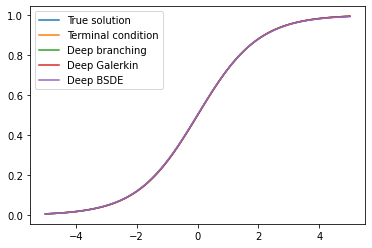

In [6]:
T = 0.001
dim = 1
grid_d_dim = np.concatenate((x_mid * np.ones((0, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)    
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)
deriv_map = np.concatenate((np.array([[0] * dim]), 1 * np.identity(dim), 2 * np.identity(dim)), axis=0).astype(int)

nu = dim ** 2

#grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal, \
#    f_example, deriv_map, phi_example, dgm_f_example = gen_for_generalized_burgers(n=n, T=T)
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, nu=nu, device=device, epochs=3000, fname=f"burger",
                    branch_nb_states=1000, branch_nb_path_per_state=20000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    second_order=True, branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    outlier_percentile=3,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 61 seconds; L1 error: 6.95E-04; L2 error: 7.24E-07; rel error: 8.52E-03.
fdb runtime: 0 seconds; total runtime: 61 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 77 seconds; L1 error: 9.74E-04; L2 error: 1.19E-06; rel error: 1.94E-02.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 139 seconds; L1 error: 1.85E-03; L2 error: 4.16E-06; rel error: 2.47E-02.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 65 seconds; L1 error: 4.69E-04; L2 error: 3.07E-07; rel error: 9.35E-03.
fdb runtime: 0 seconds; total runtime: 65 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 79 seconds; L1 error: 3.33E-04; L2 error: 1.87E-07; rel error: 1.09E-02.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 142 seconds; L1 error: 4.40E-03; L2 error: 2.69E-05; rel error: 4.27E-02.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 59 seconds; L1 error: 7.79E-04; L2 error: 9.75E-07; rel error: 1.25E-02.
fdb runtime: 0 seconds; total runtime: 59 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 81 seconds; L1 error: 4.27E-04; L2 error: 2.70E-07; rel error: 7.39E-03.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 142 seconds; L1 error: 2.69E-03; L2 error: 8.62E-06; rel error: 3.76E-02.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 61 seconds; L1 error: 4.35E-04; L2 error: 2.73E-07; rel error: 6.72E-03.
fdb runtime: 0 seconds; total runtime: 61 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 83 seconds; L1 error: 6.87E-04; L2 error: 6.86E-07; rel error: 8.60E-03.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 148 seconds; L1 error: 1.97E-03; L2 error: 5.51E-06; rel error: 4.49E-02.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 63 seconds; L1 error: 5.31E-04; L2 error: 4.17E-07; rel error: 7.65E-03.
fdb runtime: 0 seconds; total runtime: 63 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 76 seconds; L1 error: 2.92E-04; L2 error: 1.19E-07; rel error: 2.79E-03.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 141 seconds; L1 error: 5.55E-03; L2 error: 3.47E-05; rel error: 6.12E-02.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 60 seconds; L1 error: 3.49E-04; L2 error: 1.69E-07; rel error: 4.14E-03.
fdb runtime: 0 seconds; total runtime: 60 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 76 seconds; L1 error: 4.11E-04; L2 error: 2.17E-07; rel error: 6.38E-03.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 144 seconds; L1 error: 8.13E-04; L2 error: 8.39E-07; rel error: 1.40E-02.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 63 seconds; L1 error: 4.52E-04; L2 error: 2.82E-07; rel error: 7.98E-03.
fdb runtime: 0 seconds; total runtime: 63 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 79 seconds; L1 error: 7.11E-04; L2 error: 7.79E-07; rel error: 2.21E-02.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 146 seconds; L1 error: 1.14E-03; L2 error: 2.02E-06; rel error: 1.36E-02.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 61 seconds; L1 error: 6.68E-04; L2 error: 7.60E-07; rel error: 8.99E-03.
fdb runtime: 0 seconds; total runtime: 61 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 76 seconds; L1 error: 6.01E-04; L2 error: 5.54E-07; rel error: 7.38E-03.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 140 seconds; L1 error: 4.94E-03; L2 error: 3.44E-05; rel error: 3.59E-02.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 64 seconds; L1 error: 5.19E-04; L2 error: 4.53E-07; rel error: 3.91E-03.
fdb runtime: 0 seconds; total runtime: 64 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 84 seconds; L1 error: 3.73E-04; L2 error: 2.15E-07; rel error: 4.67E-03.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 139 seconds; L1 error: 3.31E-03; L2 error: 1.78E-05; rel error: 1.53E-02.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 65 seconds; L1 error: 6.63E-04; L2 error: 6.91E-07; rel error: 1.19E-02.
fdb runtime: 0 seconds; total runtime: 65 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 81 seconds; L1 error: 8.13E-04; L2 error: 9.80E-07; rel error: 1.81E-02.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 148 seconds; L1 error: 2.75E-03; L2 error: 1.09E-05; rel error: 2.41E-02.




######## Summary for deep branching method
runtime:        62
fdb runtime:    0
total runtime:  62
mean L1 error:  5.56E-04
std L1 error:   1.31E-04
mean L2 error:  5.05E-07
std L2 error:   2.52E-07
mean rel error: 8.17E-03
std rel error:  2.68E-03


######## Summary for deep galerkin method
runtime:        79
mean L1 error:  5.62E-04
std L1 error:   2.18E-04
mean L2 error:  5.20E-07
std L2 error:   3.58E-07
mean rel error: 1.08E-02
std rel error:  6.37E-03


######## Summary for deep BSDE method
runtime:        143
mean L1 error:  2.94E-03
std L1 err

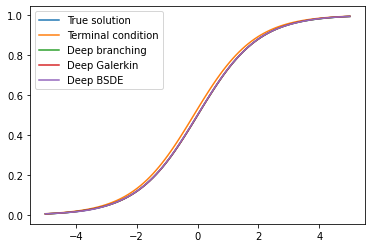

In [7]:
T = 0.125
dim = 1
grid_d_dim = np.concatenate((x_mid * np.ones((0, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)    
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)
deriv_map = np.concatenate((np.array([[0] * dim]), 1 * np.identity(dim), 2 * np.identity(dim)), axis=0).astype(int)

nu = dim ** 2

#grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal, \
#    f_example, deriv_map, phi_example, dgm_f_example = gen_for_generalized_burgers(n=n, T=T)
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, nu=nu, device=device, epochs=3000, fname=f"burger",
                    branch_nb_states=1000, branch_nb_path_per_state=20000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    second_order=True, branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    outlier_percentile=3,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 62 seconds; L1 error: 8.38E-04; L2 error: 1.12E-06; rel error: 9.93E-03.
fdb runtime: 0 seconds; total runtime: 62 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 85 seconds; L1 error: 3.88E-04; L2 error: 2.63E-07; rel error: 1.16E-02.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 136 seconds; L1 error: 2.38E-03; L2 error: 8.95E-06; rel error: 3.41E-02.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 62 seconds; L1 error: 5.76E-04; L2 error: 5.15E-07; rel error: 1.23E-02.
fdb runtime: 0 seconds; total runtime: 62 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 83 seconds; L1 error: 3.27E-04; L2 error: 1.75E-07; rel error: 8.85E-03.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 139 seconds; L1 error: 4.57E-03; L2 error: 2.95E-05; rel error: 3.96E-02.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 62 seconds; L1 error: 8.79E-04; L2 error: 1.17E-06; rel error: 1.34E-02.
fdb runtime: 0 seconds; total runtime: 62 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 79 seconds; L1 error: 3.96E-04; L2 error: 2.19E-07; rel error: 6.07E-03.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 146 seconds; L1 error: 2.79E-03; L2 error: 1.06E-05; rel error: 6.30E-02.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 64 seconds; L1 error: 6.47E-04; L2 error: 8.59E-07; rel error: 8.99E-03.
fdb runtime: 0 seconds; total runtime: 64 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 79 seconds; L1 error: 5.94E-04; L2 error: 5.54E-07; rel error: 4.15E-03.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 145 seconds; L1 error: 1.45E-03; L2 error: 3.28E-06; rel error: 3.10E-02.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 64 seconds; L1 error: 7.26E-04; L2 error: 7.64E-07; rel error: 9.00E-03.
fdb runtime: 0 seconds; total runtime: 64 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 74 seconds; L1 error: 2.00E-04; L2 error: 5.72E-08; rel error: 2.11E-03.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 142 seconds; L1 error: 5.81E-03; L2 error: 4.00E-05; rel error: 6.48E-02.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 62 seconds; L1 error: 4.36E-04; L2 error: 2.95E-07; rel error: 5.71E-03.
fdb runtime: 0 seconds; total runtime: 62 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 81 seconds; L1 error: 2.79E-04; L2 error: 1.04E-07; rel error: 4.67E-03.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 146 seconds; L1 error: 1.73E-03; L2 error: 4.39E-06; rel error: 3.00E-02.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 63 seconds; L1 error: 6.08E-04; L2 error: 5.53E-07; rel error: 1.10E-02.
fdb runtime: 0 seconds; total runtime: 63 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 85 seconds; L1 error: 5.94E-04; L2 error: 5.91E-07; rel error: 1.65E-02.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 143 seconds; L1 error: 1.42E-03; L2 error: 3.11E-06; rel error: 3.43E-02.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 64 seconds; L1 error: 7.38E-04; L2 error: 1.16E-06; rel error: 9.13E-03.
fdb runtime: 0 seconds; total runtime: 64 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 85 seconds; L1 error: 9.11E-04; L2 error: 1.12E-06; rel error: 1.53E-02.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 137 seconds; L1 error: 4.46E-03; L2 error: 3.02E-05; rel error: 1.98E-02.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 64 seconds; L1 error: 6.12E-04; L2 error: 6.93E-07; rel error: 1.00E-02.
fdb runtime: 0 seconds; total runtime: 64 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 82 seconds; L1 error: 3.50E-04; L2 error: 1.83E-07; rel error: 5.80E-03.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 144 seconds; L1 error: 3.06E-03; L2 error: 1.24E-05; rel error: 3.37E-02.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 67 seconds; L1 error: 8.00E-04; L2 error: 1.36E-06; rel error: 9.81E-03.
fdb runtime: 0 seconds; total runtime: 67 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 81 seconds; L1 error: 7.72E-04; L2 error: 1.03E-06; rel error: 1.71E-02.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 143 seconds; L1 error: 2.14E-03; L2 error: 7.55E-06; rel error: 1.76E-02.




######## Summary for deep branching method
runtime:        63
fdb runtime:    0
total runtime:  63
mean L1 error:  6.86E-04
std L1 error:   1.29E-04
mean L2 error:  8.49E-07
std L2 error:   3.27E-07
mean rel error: 9.93E-03
std rel error:  1.98E-03


######## Summary for deep galerkin method
runtime:        81
mean L1 error:  4.81E-04
std L1 error:   2.17E-04
mean L2 error:  4.29E-07
std L2 error:   3.63E-07
mean rel error: 9.22E-03
std rel error:  5.26E-03


######## Summary for deep BSDE method
runtime:        142
mean L1 error:  2.98E-03
std L1 err

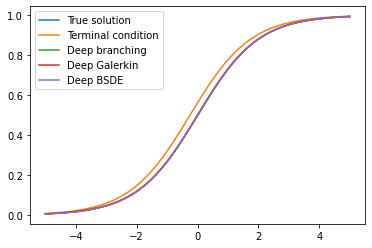

In [8]:
T = 0.250
dim = 1
grid_d_dim = np.concatenate((x_mid * np.ones((0, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)    
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)
deriv_map = np.concatenate((np.array([[0] * dim]), 1 * np.identity(dim), 2 * np.identity(dim)), axis=0).astype(int)

nu = dim ** 2

#grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal, \
#    f_example, deriv_map, phi_example, dgm_f_example = gen_for_generalized_burgers(n=n, T=T)
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, nu=nu, device=device, epochs=3000, fname=f"burger",
                    branch_nb_states=1000, branch_nb_path_per_state=20000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    second_order=True, branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    outlier_percentile=3,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 64 seconds; L1 error: 1.03E-03; L2 error: 2.03E-06; rel error: 1.40E-02.
fdb runtime: 0 seconds; total runtime: 64 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 79 seconds; L1 error: 1.21E-03; L2 error: 1.74E-06; rel error: 2.40E-02.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 145 seconds; L1 error: 3.19E-03; L2 error: 1.35E-05; rel error: 5.94E-02.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 65 seconds; L1 error: 1.03E-03; L2 error: 2.03E-06; rel error: 1.26E-02.
fdb runtime: 0 seconds; total runtime: 65 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 81 seconds; L1 error: 2.85E-04; L2 error: 1.20E-07; rel error: 7.07E-03.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 146 seconds; L1 error: 4.51E-03; L2 error: 3.44E-05; rel error: 1.89E-02.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 63 seconds; L1 error: 1.03E-03; L2 error: 1.77E-06; rel error: 1.61E-02.
fdb runtime: 0 seconds; total runtime: 63 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 73 seconds; L1 error: 3.87E-04; L2 error: 2.39E-07; rel error: 6.09E-03.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 143 seconds; L1 error: 3.43E-03; L2 error: 1.98E-05; rel error: 3.80E-02.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 64 seconds; L1 error: 7.91E-04; L2 error: 1.19E-06; rel error: 1.12E-02.
fdb runtime: 0 seconds; total runtime: 64 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 75 seconds; L1 error: 5.31E-04; L2 error: 3.93E-07; rel error: 5.20E-03.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 147 seconds; L1 error: 1.67E-03; L2 error: 4.45E-06; rel error: 1.80E-02.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 62 seconds; L1 error: 1.16E-03; L2 error: 2.10E-06; rel error: 1.50E-02.
fdb runtime: 0 seconds; total runtime: 62 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 80 seconds; L1 error: 1.38E-04; L2 error: 2.86E-08; rel error: 1.78E-03.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 143 seconds; L1 error: 6.22E-03; L2 error: 5.18E-05; rel error: 8.97E-02.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 60 seconds; L1 error: 9.07E-04; L2 error: 1.59E-06; rel error: 1.13E-02.
fdb runtime: 0 seconds; total runtime: 60 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 81 seconds; L1 error: 3.02E-04; L2 error: 1.37E-07; rel error: 6.67E-03.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 139 seconds; L1 error: 1.85E-03; L2 error: 5.50E-06; rel error: 3.23E-02.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 63 seconds; L1 error: 8.89E-04; L2 error: 1.30E-06; rel error: 1.76E-02.
fdb runtime: 0 seconds; total runtime: 63 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 81 seconds; L1 error: 4.66E-04; L2 error: 3.39E-07; rel error: 1.23E-02.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 145 seconds; L1 error: 1.83E-03; L2 error: 5.19E-06; rel error: 2.94E-02.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 60 seconds; L1 error: 1.19E-03; L2 error: 4.74E-06; rel error: 1.29E-02.
fdb runtime: 0 seconds; total runtime: 60 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 70 seconds; L1 error: 8.72E-04; L2 error: 1.01E-06; rel error: 2.13E-02.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 141 seconds; L1 error: 4.33E-03; L2 error: 3.07E-05; rel error: 2.35E-02.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 62 seconds; L1 error: 7.76E-04; L2 error: 9.43E-07; rel error: 1.46E-02.
fdb runtime: 0 seconds; total runtime: 62 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 74 seconds; L1 error: 3.40E-04; L2 error: 1.66E-07; rel error: 7.00E-03.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 146 seconds; L1 error: 3.01E-03; L2 error: 1.54E-05; rel error: 1.28E-02.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 64 seconds; L1 error: 1.06E-03; L2 error: 2.30E-06; rel error: 1.14E-02.
fdb runtime: 0 seconds; total runtime: 64 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 79 seconds; L1 error: 9.02E-04; L2 error: 1.25E-06; rel error: 1.88E-02.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 139 seconds; L1 error: 2.17E-03; L2 error: 6.65E-06; rel error: 3.20E-02.




######## Summary for deep branching method
runtime:        63
fdb runtime:    0
total runtime:  63
mean L1 error:  9.87E-04
std L1 error:   1.35E-04
mean L2 error:  2.00E-06
std L2 error:   1.00E-06
mean rel error: 1.37E-02
std rel error:  2.06E-03


######## Summary for deep galerkin method
runtime:        77
mean L1 error:  5.44E-04
std L1 error:   3.24E-04
mean L2 error:  5.42E-07
std L2 error:   5.52E-07
mean rel error: 1.10E-02
std rel error:  7.29E-03


######## Summary for deep BSDE method
runtime:        143
mean L1 error:  3.22E-03
std L1 err

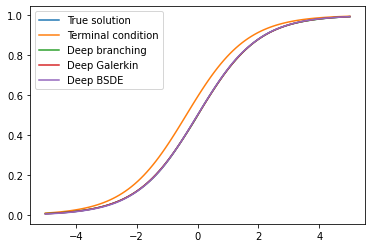

In [9]:
T = 0.375
dim = 1
grid_d_dim = np.concatenate((x_mid * np.ones((0, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)    
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)
deriv_map = np.concatenate((np.array([[0] * dim]), 1 * np.identity(dim), 2 * np.identity(dim)), axis=0).astype(int)

nu = dim ** 2

#grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal, \
#    f_example, deriv_map, phi_example, dgm_f_example = gen_for_generalized_burgers(n=n, T=T)
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, nu=nu, device=device, epochs=3000, fname=f"burger",
                    branch_nb_states=1000, branch_nb_path_per_state=20000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    second_order=True, branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    outlier_percentile=3,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 63 seconds; L1 error: 1.29E-03; L2 error: 3.46E-06; rel error: 1.84E-02.
fdb runtime: 0 seconds; total runtime: 63 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 78 seconds; L1 error: 1.29E-03; L2 error: 2.00E-06; rel error: 1.92E-02.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 141 seconds; L1 error: 3.61E-03; L2 error: 2.05E-05; rel error: 5.97E-02.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 62 seconds; L1 error: 1.50E-03; L2 error: 4.72E-06; rel error: 1.77E-02.
fdb runtime: 0 seconds; total runtime: 62 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 88 seconds; L1 error: 3.42E-04; L2 error: 2.01E-07; rel error: 1.08E-02.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 145 seconds; L1 error: 4.83E-03; L2 error: 3.85E-05; rel error: 2.12E-02.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 59 seconds; L1 error: 1.22E-03; L2 error: 2.64E-06; rel error: 2.04E-02.
fdb runtime: 0 seconds; total runtime: 59 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 77 seconds; L1 error: 4.02E-04; L2 error: 2.90E-07; rel error: 8.23E-03.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 144 seconds; L1 error: 3.91E-03; L2 error: 2.39E-05; rel error: 6.81E-02.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 59 seconds; L1 error: 1.39E-03; L2 error: 3.62E-06; rel error: 1.72E-02.
fdb runtime: 0 seconds; total runtime: 59 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 77 seconds; L1 error: 5.12E-04; L2 error: 3.25E-07; rel error: 8.19E-03.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 148 seconds; L1 error: 2.80E-03; L2 error: 9.90E-06; rel error: 4.47E-02.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 61 seconds; L1 error: 1.67E-03; L2 error: 5.18E-06; rel error: 2.47E-02.
fdb runtime: 0 seconds; total runtime: 61 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 81 seconds; L1 error: 1.63E-04; L2 error: 3.17E-08; rel error: 2.31E-03.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 148 seconds; L1 error: 7.31E-03; L2 error: 6.34E-05; rel error: 1.16E-01.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 62 seconds; L1 error: 1.49E-03; L2 error: 4.46E-06; rel error: 1.81E-02.
fdb runtime: 0 seconds; total runtime: 62 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 68 seconds; L1 error: 4.11E-04; L2 error: 2.75E-07; rel error: 1.11E-02.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 150 seconds; L1 error: 2.35E-03; L2 error: 1.00E-05; rel error: 2.55E-02.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 63 seconds; L1 error: 1.56E-03; L2 error: 4.31E-06; rel error: 2.66E-02.
fdb runtime: 0 seconds; total runtime: 63 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 82 seconds; L1 error: 4.56E-04; L2 error: 4.50E-07; rel error: 1.85E-02.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 148 seconds; L1 error: 2.94E-03; L2 error: 1.33E-05; rel error: 5.35E-02.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 63 seconds; L1 error: 1.43E-03; L2 error: 3.56E-06; rel error: 1.83E-02.
fdb runtime: 0 seconds; total runtime: 63 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 91 seconds; L1 error: 8.19E-04; L2 error: 8.82E-07; rel error: 2.25E-02.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 150 seconds; L1 error: 4.05E-03; L2 error: 3.16E-05; rel error: 2.87E-02.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 63 seconds; L1 error: 1.01E-03; L2 error: 1.72E-06; rel error: 2.18E-02.
fdb runtime: 0 seconds; total runtime: 63 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 78 seconds; L1 error: 3.61E-04; L2 error: 1.81E-07; rel error: 8.79E-03.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 150 seconds; L1 error: 3.51E-03; L2 error: 1.83E-05; rel error: 3.13E-02.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 66 seconds; L1 error: 1.57E-03; L2 error: 7.75E-06; rel error: 1.40E-02.
fdb runtime: 0 seconds; total runtime: 66 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 85 seconds; L1 error: 9.85E-04; L2 error: 1.36E-06; rel error: 2.24E-02.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 149 seconds; L1 error: 3.88E-03; L2 error: 1.74E-05; rel error: 5.93E-02.




######## Summary for deep branching method
runtime:        62
fdb runtime:    0
total runtime:  62
mean L1 error:  1.41E-03
std L1 error:   1.85E-04
mean L2 error:  4.14E-06
std L2 error:   1.54E-06
mean rel error: 1.97E-02
std rel error:  3.57E-03


######## Summary for deep galerkin method
runtime:        81
mean L1 error:  5.75E-04
std L1 error:   3.30E-04
mean L2 error:  6.00E-07
std L2 error:   5.99E-07
mean rel error: 1.32E-02
std rel error:  6.57E-03


######## Summary for deep BSDE method
runtime:        147
mean L1 error:  3.92E-03
std L1 err

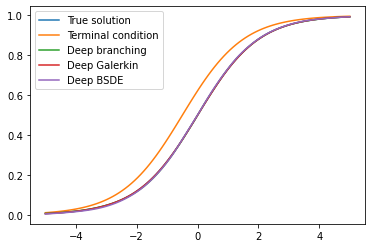

In [10]:
T = 0.5
dim = 1
grid_d_dim = np.concatenate((x_mid * np.ones((0, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)    
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)
deriv_map = np.concatenate((np.array([[0] * dim]), 1 * np.identity(dim), 2 * np.identity(dim)), axis=0).astype(int)

nu = dim ** 2

#grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal, \
#    f_example, deriv_map, phi_example, dgm_f_example = gen_for_generalized_burgers(n=n, T=T)
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, nu=nu, device=device, epochs=3000, fname=f"burger",
                    branch_nb_states=1000, branch_nb_path_per_state=20000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    second_order=True, branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    outlier_percentile=3,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 58 seconds; L1 error: 1.70E-03; L2 error: 6.65E-06; rel error: 1.68E-02.
fdb runtime: 0 seconds; total runtime: 58 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 80 seconds; L1 error: 1.73E-03; L2 error: 3.48E-06; rel error: 2.34E-02.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 150 seconds; L1 error: 4.13E-03; L2 error: 3.02E-05; rel error: 5.71E-02.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 60 seconds; L1 error: 2.54E-03; L2 error: 1.45E-05; rel error: 2.46E-02.
fdb runtime: 0 seconds; total runtime: 60 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 82 seconds; L1 error: 3.95E-04; L2 error: 2.93E-07; rel error: 1.43E-02.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 149 seconds; L1 error: 5.61E-03; L2 error: 4.95E-05; rel error: 4.17E-02.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 60 seconds; L1 error: 1.42E-03; L2 error: 3.40E-06; rel error: 2.14E-02.
fdb runtime: 0 seconds; total runtime: 60 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 77 seconds; L1 error: 4.10E-04; L2 error: 3.22E-07; rel error: 1.31E-02.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 144 seconds; L1 error: 4.66E-03; L2 error: 3.86E-05; rel error: 5.65E-02.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 60 seconds; L1 error: 2.65E-03; L2 error: 1.16E-05; rel error: 2.50E-02.
fdb runtime: 0 seconds; total runtime: 60 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 78 seconds; L1 error: 4.91E-04; L2 error: 3.03E-07; rel error: 1.06E-02.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 150 seconds; L1 error: 3.50E-03; L2 error: 1.75E-05; rel error: 5.06E-02.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 58 seconds; L1 error: 2.56E-03; L2 error: 1.36E-05; rel error: 4.30E-02.
fdb runtime: 0 seconds; total runtime: 58 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 67 seconds; L1 error: 1.91E-04; L2 error: 4.87E-08; rel error: 2.82E-03.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 149 seconds; L1 error: 7.10E-03; L2 error: 6.46E-05; rel error: 1.01E-01.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 63 seconds; L1 error: 2.10E-03; L2 error: 9.22E-06; rel error: 1.67E-02.
fdb runtime: 0 seconds; total runtime: 63 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 73 seconds; L1 error: 5.62E-04; L2 error: 5.60E-07; rel error: 1.84E-02.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 149 seconds; L1 error: 2.87E-03; L2 error: 1.20E-05; rel error: 4.38E-02.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 61 seconds; L1 error: 2.25E-03; L2 error: 9.87E-06; rel error: 2.71E-02.
fdb runtime: 0 seconds; total runtime: 61 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 75 seconds; L1 error: 6.02E-04; L2 error: 1.03E-06; rel error: 3.23E-02.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 149 seconds; L1 error: 3.48E-03; L2 error: 2.50E-05; rel error: 5.93E-02.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 62 seconds; L1 error: 2.05E-03; L2 error: 8.07E-06; rel error: 2.61E-02.
fdb runtime: 0 seconds; total runtime: 62 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 76 seconds; L1 error: 9.36E-04; L2 error: 1.29E-06; rel error: 3.13E-02.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 149 seconds; L1 error: 4.70E-03; L2 error: 3.98E-05; rel error: 3.65E-02.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 63 seconds; L1 error: 1.82E-03; L2 error: 5.43E-06; rel error: 2.12E-02.
fdb runtime: 0 seconds; total runtime: 63 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 72 seconds; L1 error: 3.94E-04; L2 error: 2.20E-07; rel error: 1.12E-02.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 147 seconds; L1 error: 4.34E-03; L2 error: 2.54E-05; rel error: 3.65E-02.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 64 seconds; L1 error: 2.81E-03; L2 error: 2.25E-05; rel error: 2.82E-02.
fdb runtime: 0 seconds; total runtime: 64 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 77 seconds; L1 error: 1.00E-03; L2 error: 1.49E-06; rel error: 2.86E-02.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 147 seconds; L1 error: 5.01E-03; L2 error: 3.08E-05; rel error: 6.57E-02.




######## Summary for deep branching method
runtime:        61
fdb runtime:    0
total runtime:  61
mean L1 error:  2.19E-03
std L1 error:   4.32E-04
mean L2 error:  1.05E-05
std L2 error:   5.21E-06
mean rel error: 2.50E-02
std rel error:  7.10E-03


######## Summary for deep galerkin method
runtime:        76
mean L1 error:  6.71E-04
std L1 error:   4.23E-04
mean L2 error:  9.04E-07
std L2 error:   9.78E-07
mean rel error: 1.86E-02
std rel error:  9.42E-03


######## Summary for deep BSDE method
runtime:        148
mean L1 error:  4.54E-03
std L1 err

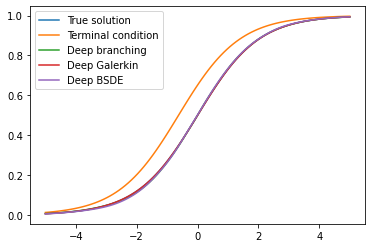

In [11]:
T = 0.625
dim = 1
grid_d_dim = np.concatenate((x_mid * np.ones((0, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)    
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)
deriv_map = np.concatenate((np.array([[0] * dim]), 1 * np.identity(dim), 2 * np.identity(dim)), axis=0).astype(int)

nu = dim ** 2

#grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal, \
#    f_example, deriv_map, phi_example, dgm_f_example = gen_for_generalized_burgers(n=n, T=T)
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, nu=nu, device=device, epochs=3000, fname=f"burger",
                    branch_nb_states=1000, branch_nb_path_per_state=20000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    second_order=True, branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    outlier_percentile=3,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 62 seconds; L1 error: 2.87E-03; L2 error: 2.14E-05; rel error: 3.03E-02.
fdb runtime: 0 seconds; total runtime: 62 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 84 seconds; L1 error: 1.98E-03; L2 error: 4.70E-06; rel error: 2.45E-02.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 147 seconds; L1 error: 4.93E-03; L2 error: 4.64E-05; rel error: 6.11E-02.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 62 seconds; L1 error: 4.04E-03; L2 error: 3.32E-05; rel error: 5.57E-02.
fdb runtime: 0 seconds; total runtime: 62 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 78 seconds; L1 error: 4.90E-04; L2 error: 4.75E-07; rel error: 1.97E-02.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 148 seconds; L1 error: 6.51E-03; L2 error: 6.52E-05; rel error: 6.33E-02.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 62 seconds; L1 error: 2.32E-03; L2 error: 9.71E-06; rel error: 1.87E-02.
fdb runtime: 0 seconds; total runtime: 62 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 72 seconds; L1 error: 4.39E-04; L2 error: 3.28E-07; rel error: 1.23E-02.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 146 seconds; L1 error: 5.08E-03; L2 error: 5.73E-05; rel error: 5.92E-02.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 57 seconds; L1 error: 4.17E-03; L2 error: 3.01E-05; rel error: 6.58E-02.
fdb runtime: 0 seconds; total runtime: 57 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 79 seconds; L1 error: 4.79E-04; L2 error: 3.32E-07; rel error: 1.30E-02.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 150 seconds; L1 error: 5.03E-03; L2 error: 4.02E-05; rel error: 5.28E-02.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 58 seconds; L1 error: 3.39E-03; L2 error: 2.56E-05; rel error: 6.84E-02.
fdb runtime: 0 seconds; total runtime: 58 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 86 seconds; L1 error: 2.46E-04; L2 error: 8.05E-08; rel error: 3.13E-03.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 148 seconds; L1 error: 7.52E-03; L2 error: 8.62E-05; rel error: 1.14E-01.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 60 seconds; L1 error: 3.39E-03; L2 error: 2.55E-05; rel error: 3.00E-02.
fdb runtime: 0 seconds; total runtime: 60 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 74 seconds; L1 error: 7.76E-04; L2 error: 1.11E-06; rel error: 2.92E-02.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 150 seconds; L1 error: 4.82E-03; L2 error: 3.99E-05; rel error: 8.69E-02.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 61 seconds; L1 error: 3.42E-03; L2 error: 2.75E-05; rel error: 2.96E-02.
fdb runtime: 0 seconds; total runtime: 61 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 89 seconds; L1 error: 7.72E-04; L2 error: 1.96E-06; rel error: 4.75E-02.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 151 seconds; L1 error: 4.88E-03; L2 error: 4.04E-05; rel error: 7.41E-02.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 62 seconds; L1 error: 3.19E-03; L2 error: 2.11E-05; rel error: 5.31E-02.
fdb runtime: 0 seconds; total runtime: 62 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 84 seconds; L1 error: 1.12E-03; L2 error: 2.31E-06; rel error: 4.77E-02.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 147 seconds; L1 error: 6.20E-03; L2 error: 6.59E-05; rel error: 5.35E-02.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 60 seconds; L1 error: 2.72E-03; L2 error: 1.38E-05; rel error: 2.38E-02.
fdb runtime: 0 seconds; total runtime: 60 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 74 seconds; L1 error: 4.39E-04; L2 error: 2.91E-07; rel error: 1.44E-02.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 149 seconds; L1 error: 5.55E-03; L2 error: 4.45E-05; rel error: 7.90E-02.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 64 seconds; L1 error: 4.02E-03; L2 error: 4.53E-05; rel error: 3.44E-02.
fdb runtime: 0 seconds; total runtime: 64 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 70 seconds; L1 error: 1.01E-03; L2 error: 1.90E-06; rel error: 3.78E-02.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 144 seconds; L1 error: 5.56E-03; L2 error: 4.02E-05; rel error: 7.47E-02.




######## Summary for deep branching method
runtime:        61
fdb runtime:    0
total runtime:  61
mean L1 error:  3.35E-03
std L1 error:   5.76E-04
mean L2 error:  2.53E-05
std L2 error:   9.48E-06
mean rel error: 4.10E-02
std rel error:  1.71E-02


######## Summary for deep galerkin method
runtime:        79
mean L1 error:  7.75E-04
std L1 error:   4.79E-04
mean L2 error:  1.35E-06
std L2 error:   1.36E-06
mean rel error: 2.49E-02
std rel error:  1.46E-02


######## Summary for deep BSDE method
runtime:        148
mean L1 error:  5.61E-03
std L1 err

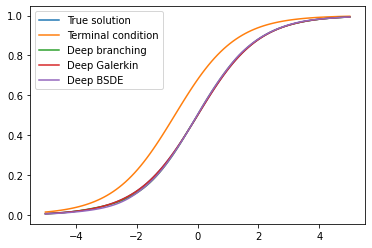

In [12]:
T = 0.75
dim = 1
grid_d_dim = np.concatenate((x_mid * np.ones((0, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)    
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)
deriv_map = np.concatenate((np.array([[0] * dim]), 1 * np.identity(dim), 2 * np.identity(dim)), axis=0).astype(int)

nu = dim ** 2

#grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal, \
#    f_example, deriv_map, phi_example, dgm_f_example = gen_for_generalized_burgers(n=n, T=T)
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, nu=nu, device=device, epochs=3000, fname=f"burger",
                    branch_nb_states=1000, branch_nb_path_per_state=20000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    second_order=True, branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    outlier_percentile=3,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 62 seconds; L1 error: 4.24E-03; L2 error: 3.79E-05; rel error: 6.92E-02.
fdb runtime: 0 seconds; total runtime: 62 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 71 seconds; L1 error: 1.26E-03; L2 error: 3.64E-06; rel error: 6.35E-02.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 147 seconds; L1 error: 5.94E-03; L2 error: 7.06E-05; rel error: 7.38E-02.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 62 seconds; L1 error: 5.92E-03; L2 error: 6.87E-05; rel error: 1.00E-01.
fdb runtime: 0 seconds; total runtime: 62 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 92 seconds; L1 error: 6.10E-04; L2 error: 7.28E-07; rel error: 2.52E-02.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 144 seconds; L1 error: 7.51E-03; L2 error: 9.00E-05; rel error: 5.92E-02.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 62 seconds; L1 error: 4.78E-03; L2 error: 3.57E-05; rel error: 7.75E-02.
fdb runtime: 0 seconds; total runtime: 62 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 70 seconds; L1 error: 5.26E-04; L2 error: 4.70E-07; rel error: 1.60E-02.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 146 seconds; L1 error: 6.82E-03; L2 error: 8.67E-05; rel error: 8.77E-02.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 59 seconds; L1 error: 6.46E-03; L2 error: 7.00E-05; rel error: 1.16E-01.
fdb runtime: 0 seconds; total runtime: 59 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 77 seconds; L1 error: 5.13E-04; L2 error: 4.15E-07; rel error: 1.64E-02.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 139 seconds; L1 error: 6.08E-03; L2 error: 7.15E-05; rel error: 9.17E-02.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 59 seconds; L1 error: 5.14E-03; L2 error: 5.36E-05; rel error: 1.08E-01.
fdb runtime: 0 seconds; total runtime: 59 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 67 seconds; L1 error: 3.42E-04; L2 error: 1.50E-07; rel error: 4.84E-03.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 137 seconds; L1 error: 7.97E-03; L2 error: 1.22E-04; rel error: 1.11E-01.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 58 seconds; L1 error: 5.43E-03; L2 error: 5.73E-05; rel error: 7.08E-02.
fdb runtime: 0 seconds; total runtime: 58 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 56 seconds; L1 error: 8.89E-04; L2 error: 1.55E-06; rel error: 3.60E-02.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 144 seconds; L1 error: 6.93E-03; L2 error: 7.62E-05; rel error: 9.87E-02.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 62 seconds; L1 error: 4.99E-03; L2 error: 6.03E-05; rel error: 4.83E-02.
fdb runtime: 0 seconds; total runtime: 62 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 66 seconds; L1 error: 9.26E-04; L2 error: 3.17E-06; rel error: 6.16E-02.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 142 seconds; L1 error: 5.84E-03; L2 error: 6.28E-05; rel error: 9.26E-02.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 59 seconds; L1 error: 4.25E-03; L2 error: 3.68E-05; rel error: 7.95E-02.
fdb runtime: 0 seconds; total runtime: 59 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 76 seconds; L1 error: 1.53E-03; L2 error: 5.64E-06; rel error: 7.93E-02.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 148 seconds; L1 error: 7.68E-03; L2 error: 8.66E-05; rel error: 8.51E-02.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 62 seconds; L1 error: 4.20E-03; L2 error: 2.94E-05; rel error: 6.27E-02.
fdb runtime: 0 seconds; total runtime: 62 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 85 seconds; L1 error: 4.80E-04; L2 error: 4.09E-07; rel error: 1.91E-02.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 142 seconds; L1 error: 7.20E-03; L2 error: 7.15E-05; rel error: 7.22E-02.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 62 seconds; L1 error: 6.42E-03; L2 error: 1.00E-04; rel error: 8.40E-02.
fdb runtime: 0 seconds; total runtime: 63 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 81 seconds; L1 error: 1.07E-03; L2 error: 2.81E-06; rel error: 5.06E-02.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 144 seconds; L1 error: 6.52E-03; L2 error: 6.94E-05; rel error: 8.51E-02.




######## Summary for deep branching method
runtime:        61
fdb runtime:    0
total runtime:  61
mean L1 error:  5.18E-03
std L1 error:   8.16E-04
mean L2 error:  5.50E-05
std L2 error:   2.04E-05
mean rel error: 8.16E-02
std rel error:  2.00E-02


######## Summary for deep galerkin method
runtime:        74
mean L1 error:  8.13E-04
std L1 error:   3.65E-04
mean L2 error:  1.90E-06
std L2 error:   1.75E-06
mean rel error: 3.72E-02
std rel error:  2.38E-02


######## Summary for deep BSDE method
runtime:        143
mean L1 error:  6.85E-03
std L1 err

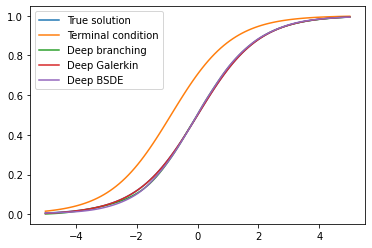

In [13]:
T = 0.875
dim = 1
grid_d_dim = np.concatenate((x_mid * np.ones((0, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)    
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)
deriv_map = np.concatenate((np.array([[0] * dim]), 1 * np.identity(dim), 2 * np.identity(dim)), axis=0).astype(int)

nu = dim ** 2

#grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal, \
#    f_example, deriv_map, phi_example, dgm_f_example = gen_for_generalized_burgers(n=n, T=T)
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, nu=nu, device=device, epochs=3000, fname=f"burger",
                    branch_nb_states=1000, branch_nb_path_per_state=20000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    second_order=True, branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    outlier_percentile=3,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 62 seconds; L1 error: 6.42E-03; L2 error: 7.47E-05; rel error: 1.33E-01.
fdb runtime: 0 seconds; total runtime: 62 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 74 seconds; L1 error: 1.28E-03; L2 error: 5.47E-06; rel error: 8.10E-02.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 146 seconds; L1 error: 9.04E-03; L2 error: 1.58E-04; rel error: 1.26E-01.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 64 seconds; L1 error: 7.89E-03; L2 error: 1.19E-04; rel error: 1.77E-01.
fdb runtime: 0 seconds; total runtime: 64 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 65 seconds; L1 error: 7.69E-04; L2 error: 1.19E-06; rel error: 3.35E-02.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 136 seconds; L1 error: 1.01E-02; L2 error: 1.49E-04; rel error: 8.52E-02.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 60 seconds; L1 error: 7.02E-03; L2 error: 7.34E-05; rel error: 1.65E-01.
fdb runtime: 0 seconds; total runtime: 60 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 69 seconds; L1 error: 6.32E-04; L2 error: 7.66E-07; rel error: 2.32E-02.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 149 seconds; L1 error: 7.43E-03; L2 error: 1.17E-04; rel error: 1.06E-01.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 61 seconds; L1 error: 9.05E-03; L2 error: 1.39E-04; rel error: 1.96E-01.
fdb runtime: 0 seconds; total runtime: 61 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 75 seconds; L1 error: 5.29E-04; L2 error: 4.46E-07; rel error: 1.74E-02.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 143 seconds; L1 error: 7.69E-03; L2 error: 9.99E-05; rel error: 9.99E-02.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 60 seconds; L1 error: 7.08E-03; L2 error: 1.02E-04; rel error: 1.54E-01.
fdb runtime: 0 seconds; total runtime: 60 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 80 seconds; L1 error: 4.58E-04; L2 error: 2.73E-07; rel error: 8.85E-03.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 140 seconds; L1 error: 9.78E-03; L2 error: 1.93E-04; rel error: 1.40E-01.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 60 seconds; L1 error: 8.52E-03; L2 error: 1.24E-04; rel error: 1.52E-01.
fdb runtime: 0 seconds; total runtime: 60 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 74 seconds; L1 error: 9.77E-04; L2 error: 2.01E-06; rel error: 4.22E-02.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 146 seconds; L1 error: 8.69E-03; L2 error: 1.23E-04; rel error: 1.97E-01.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 61 seconds; L1 error: 7.17E-03; L2 error: 1.12E-04; rel error: 1.13E-01.
fdb runtime: 0 seconds; total runtime: 61 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 72 seconds; L1 error: 1.36E-03; L2 error: 3.58E-06; rel error: 4.86E-02.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 140 seconds; L1 error: 7.40E-03; L2 error: 1.09E-04; rel error: 9.13E-02.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 62 seconds; L1 error: 6.21E-03; L2 error: 6.95E-05; rel error: 1.39E-01.
fdb runtime: 0 seconds; total runtime: 62 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 83 seconds; L1 error: 2.20E-03; L2 error: 1.53E-05; rel error: 1.34E-01.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 144 seconds; L1 error: 1.19E-02; L2 error: 1.97E-04; rel error: 1.89E-01.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 59 seconds; L1 error: 6.19E-03; L2 error: 5.85E-05; rel error: 9.34E-02.
fdb runtime: 0 seconds; total runtime: 59 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 65 seconds; L1 error: 5.49E-04; L2 error: 6.99E-07; rel error: 2.67E-02.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 141 seconds; L1 error: 8.31E-03; L2 error: 1.04E-04; rel error: 8.28E-02.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 63 seconds; L1 error: 9.33E-03; L2 error: 1.82E-04; rel error: 1.58E-01.
fdb runtime: 0 seconds; total runtime: 63 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 88 seconds; L1 error: 1.24E-03; L2 error: 4.52E-06; rel error: 6.79E-02.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 149 seconds; L1 error: 8.64E-03; L2 error: 1.10E-04; rel error: 1.12E-01.




######## Summary for deep branching method
runtime:        61
fdb runtime:    0
total runtime:  61
mean L1 error:  7.49E-03
std L1 error:   1.09E-03
mean L2 error:  1.05E-04
std L2 error:   3.61E-05
mean rel error: 1.48E-01
std rel error:  2.85E-02


######## Summary for deep galerkin method
runtime:        74
mean L1 error:  1.00E-03
std L1 error:   5.11E-04
mean L2 error:  3.43E-06
std L2 error:   4.33E-06
mean rel error: 4.84E-02
std rel error:  3.56E-02


######## Summary for deep BSDE method
runtime:        143
mean L1 error:  8.90E-03
std L1 err

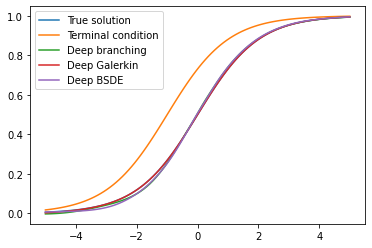

In [14]:
T = 1.0
dim = 1
grid_d_dim = np.concatenate((x_mid * np.ones((0, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)    
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)
deriv_map = np.concatenate((np.array([[0] * dim]), 1 * np.identity(dim), 2 * np.identity(dim)), axis=0).astype(int)

nu = dim ** 2

#grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal, \
#    f_example, deriv_map, phi_example, dgm_f_example = gen_for_generalized_burgers(n=n, T=T)
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, nu=nu, device=device, epochs=3000, fname=f"burger",
                    branch_nb_states=1000, branch_nb_path_per_state=20000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    second_order=True, branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    outlier_percentile=3,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)